(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Yelp Reviews and Clustering

In this assignment, we will be working with the [Yelp dataset](http://cs-people.bu.edu/kzhao/teaching/yelp_dataset_challenge_academic_dataset.tar). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

First, we will look at Review Objects and perform some [sentiment analysis](http://sentiment.christopherpotts.net/) on the review text.

You will need to preprocess the text using a stemming algorithm. The Porter stemming algorithm is a well-known one. Then, use a lexicon to assign a score to a review based on the positive/negative words you find in the text. You can find various lexicons [here](http://sentiment.christopherpotts.net/lexicons.html).

After you have assigned scores to the reviews based on the text analysis, compare your scores with the stars associated with the reviews. **(20 pts)**

In the below code I have downloaded the Bing Liu Lexicon and I have built a dictionary in which the positive words are given a score of +1 and the negative words are given a score of -1. This dictionary is used to calculate the score of each review.

In [1]:
lexicon = {}
with open('positive-words.txt') as posfile:
    for word in posfile:
        lexicon.update({word.replace('\n',''):1})

with open('negative-words.txt') as negfile:
    for word in negfile:
        lexicon.update({word.replace('\n',''):-1})

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
import nltk
from nltk.stem import PorterStemmer
jsondict = {}
stemmer = PorterStemmer()
actual_stars = []
reviewtextData = []
with open('yelp_academic_dataset_review.json') as f:
    for line in f:
        jsonData = json.loads(line)
        actual_stars.append(jsonData["stars"])
        reviewtextData.append(jsonData["text"])

In the below code I iterate through each and every review in the yelp academic data set file and assign a score to it by checking if the words in the review are positive or negative by looking into the dictionary that we created above. The review_score is the difference between positive and negative words. Non existing words are considered neutral. The review score is standardized by dividing each review_score by the total number of words in it ( variable : countNonNeutral).

Using the above method we get a review_score in the range (-1,1)

I converted the above review score to five using the following formula:
    The yelp reviews we have stars from 1 to 5, so we estimate using the below formula
    round(review_score*2+3). -1 maps to 1 star and 1 maps to five star and 0 maps to 3

    

In [5]:
predicted_stars = []
def getReviewScore():
    for review_text in reviewtextData:
        countNonNeutral = 0  #Count all the words that are positive or negative
        review_score = 0     #Find the effective score (count(Positive Words) - count(Negative Words))
        for word in review_text.split(' '):
            stemmedWord = stemmer.stem(word)
            if lexicon.get(stemmedWord.lower()):
                review_score += lexicon.get(stemmedWord.lower())
                countNonNeutral += 1
        if countNonNeutral != 0:
            convert_review_score = float(review_score)/countNonNeutral
            convert_score_to_star = convert_review_score*2+3
            round_star = round(convert_score_to_star)
        else:
                round_star = 3
        predicted_stars.append(round_star)

In [6]:
getReviewScore()

# Visualization and short (detailed) analysis. **(10 pts)**

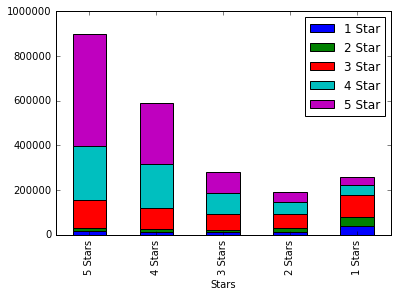

In [9]:
#Lists that stores predicted stars
p5 = [] 
p4 = []
p3 = []
p2 = []
p1 = []
#Lists that store actual stars
Astars = []
# This function appends for each actual star category, the count of actual stars and various predicted stars
# The input for this function is a dataFrame consisting of actual_stars and predicted_stars where the actual stars have
# only single value ( for example :5 )
def actualAndPredictedStars(starDataFrame):
    Astars.append(len(starDataFrame))
    p5.append(len(starDataFrame[starDataFrame['predicted_stars'] == 5]))
    p4.append(len(starDataFrame[starDataFrame['predicted_stars'] == 4]))
    p3.append(len(starDataFrame[starDataFrame['predicted_stars'] == 3]))
    p2.append(len(starDataFrame[starDataFrame['predicted_stars'] == 2]))
    p1.append(len(starDataFrame[starDataFrame['predicted_stars'] == 1]))

# We will try to plot the bar graph
StarsData = {'actual_stars':actual_stars,'predicted_stars':predicted_stars}
StarsDF = pd.DataFrame(StarsData)
#print StarsDF
dfOf5Stars = StarsDF[StarsDF['actual_stars'] == 5]
dfOf4Stars = StarsDF[StarsDF['actual_stars'] == 4]
dfOf3Stars = StarsDF[StarsDF['actual_stars'] == 3]
dfOf2Stars = StarsDF[StarsDF['actual_stars'] == 2]
dfOf1Stars = StarsDF[StarsDF['actual_stars'] == 1]
actualAndPredictedStars(dfOf5Stars)
actualAndPredictedStars(dfOf4Stars)
actualAndPredictedStars(dfOf3Stars)
actualAndPredictedStars(dfOf2Stars)
actualAndPredictedStars(dfOf1Stars)
somedata = {'5 Star':p5,'4 Star':p4,'3 Star':p3,'2 Star':p2,'1 Star':p1}
starsdf = pd.DataFrame(somedata)
somedataindex=['5 Stars','4 Stars','3 Stars','2 Stars','1 Stars']
starsdf['Stars']=somedataindex
indexed_df = starsdf.set_index(['Stars'])
stars_count = pd.DataFrame(indexed_df)
stars_count.plot(kind='bar',stacked=True)


The bar plot above gives the visualisation of our prediction. Each bar represents the size of the actual number of stars and the colors within the bar represent the size of the stars we predicted. 
    For example, the first bar represents reviews which users marked as five stars in the data. As we can see most of our prediction are in the range of 5 and 4 and few in the range of 2 and 1. As the rating decreases our prediction also gives lower rating.

Similarly as the stars rated by the reviewers decreases, our predicted stars have also decreased. On an average our predicted stars are in the (actual_stars +/- 1) range.
The above results could be improved by getting a better dictionary more suited for analysing restaurant reviews. Also, simply analysing positive and negative words without considering context and sentence structure may not be sufficient to obtain an accurate prediction.

-----------------

Now, let's look at Business Objects. Try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" and "attributes" to cluster for similarity.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

Things you may want to consider:
1. The spatial coordinates and restaurant categories/attributes have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.
2. Some restaurant types are inherently more common than others. For example, there are probably lots of "pizza" restaurants. You may want to normalize your vectors so that you don't end up with only clusters of "pizza" restaurants.

Decode the business data and get the required fields into pandas dataframe

In [10]:
import json
import pandas as pd
restaurant_Data = []
latitude=[]
longitude=[]
with open('yelp_academic_dataset_business.json') as business_file:
    for line in business_file:
        json_line = json.loads(line)
        city = json_line["city"]
        categories = json_line["categories"]
        if 'Las Vegas' in city:
            if 'Restaurants' in categories:
                restDict = {}
                restDict['id'] =  json_line['business_id']
                restDict['latitude'] = json_line['latitude']
                restDict['longitude'] = json_line['longitude']
                restDict['category'] = ' '.join(json_line['categories'])
                restaurant_Data.append(restDict)
finaldata = pd.DataFrame(restaurant_Data) 


Below, I have taken the several restaurant categories. I have used CountVectorizer to assign values of categories to restaurant. I have normalized the longitude and latitude data so that they do not skew the clusters ( mean of 0 and standard deviation of 1).

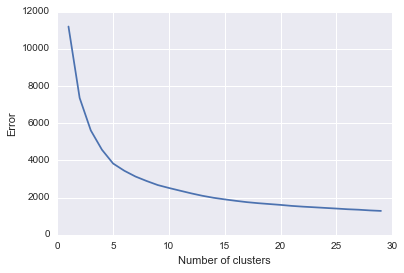

In [262]:
#find the number of clusters
import numpy as np
error = np.zeros(30)
error[0] = 0;
for k in range(1,30):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=200)
    kmeans.fit_predict(df8)
    error[k] = kmeans.inertia_

plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('Error')

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
countVector = CountVectorizer(min_df=1)
categoryDF=pd.DataFrame(countVector.fit_transform(finaldata.category).toarray(), columns=countVector.get_feature_names())
df8 = pd.concat([finaldata['latitude'],finaldata['longitude'],categoryDF['wine'],categoryDF['chinese'],categoryDF['sandwiches'],categoryDF['sushi'],categoryDF['italian'],categoryDF['indian'],categoryDF['mediterranean']],axis=1)
latstd = df8['latitude'].std()
latmean = df8['latitude'].mean()
longstd = df8['longitude'].std()
longmean = df8['longitude'].mean()
df8['latitude'] = df8['latitude'].apply(lambda x: (x-latmean)/latstd)
df8['longitude'] = df8['longitude'].apply(lambda x: (x-longmean)/longstd)

We run the above function to decide the number of clusters. I have taken the maximum number of clusters to be 30. To avoid kmeans giving local minima I have assinged n_init = 200. Based on the above graph, I have chosen the number of clusters as 15 as the error rate drops down at a slower rate after 15.

The below code runs the kmeans algorithm on the dataframe and prints the centroids and labels

In [14]:
kmeans = KMeans(init='k-means++', n_clusters=15, n_init=200)
kmeans.fit_predict(df8)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

print "The total error of the clustering is: ", error
print '\nCluster labels'
print labels
print '\n Cluster Centroids'
print centroids

The total error of the clustering is:  1904.35664852

Cluster labels
[ 2  5 12 ...,  0  8  3]

 Cluster Centroids
[[  4.58119178e-01   7.39177415e-01   4.86618005e-03   3.16301703e-02
    2.08166817e-16   1.45985401e-02   1.45985401e-02   4.86618005e-03
    1.70316302e-02]
 [ -4.40361179e-01  -1.60980442e+00   3.81639165e-17   5.92592593e-02
    8.88888889e-02   7.03703704e-02   1.03703704e-01   1.11111111e-02
    3.70370370e-02]
 [  4.21818689e-01  -1.72913311e+00   2.81250000e-02   5.93750000e-02
    9.37500000e-02   5.93750000e-02   9.06250000e-02   3.12500000e-03
    1.56250000e-02]
 [ -3.90018230e-01   3.87161278e-01   1.50375940e-02   5.27355937e-16
   -8.32667268e-17   3.75939850e-02   9.02056208e-16   1.71858217e-02
    1.82599356e-02]
 [ -1.72662288e+00   7.48118093e-01   6.59194921e-17   4.85714286e-02
    1.20000000e-01   3.42857143e-02   5.14285714e-02   8.57142857e-03
    2.85714286e-02]
 [  8.98550959e-01   1.84899568e+00   1.00000000e-02   7.00000000e-02
    9.00000000e-

I copied the dataframe with original values and normalized latitude and longitude into a new dataframe. Append actual
latitude and longitude into the data frame and also the kmeans label. Based on the kmeans label, I create subsets of 
dataframes as shown below. This is used to colour them differently and also see the composition of our clusters below.

In [15]:
df101 = pd.DataFrame.copy(df8)

df101['actual_lat'] = finaldata['latitude']
df101['actual_long'] = finaldata['longitude']
df101['labels'] = labels
df110=df101[df101['labels'] == 0]
df111=df101[df101['labels'] == 1]
df112=df101[df101['labels'] == 2]
df113=df101[df101['labels'] == 3]
df114=df101[df101['labels'] == 4]
df115=df101[df101['labels'] == 5]
df116=df101[df101['labels'] == 6]
df117=df101[df101['labels'] == 7]
df118=df101[df101['labels'] == 8]
df119=df101[df101['labels'] == 9]
df120=df101[df101['labels'] == 10]
df121=df101[df101['labels'] == 11]
df122=df101[df101['labels'] == 12]
df123=df101[df101['labels'] == 13]
df124=df101[df101['labels'] == 14]

In [16]:
def clustersOf(df):
    print "Italian :",df['italian'].sum()
    print "Wine :",df['wine'].sum()
    print "Chinese",df['chinese'].sum()
    print "sandwiches",df['sandwiches'].sum()
    print "sushi",df['sushi'].sum()
    print "indian",df['indian'].sum()
    print "mediterranean",df['mediterranean'].sum()
    print "------------------------------"

In [266]:
clustersOf(df110)
clustersOf(df111)
clustersOf(df112)
clustersOf(df113)
clustersOf(df114)
clustersOf(df115)
clustersOf(df116)
clustersOf(df117)
clustersOf(df118)
clustersOf(df119)
clustersOf(df120)
clustersOf(df121)
clustersOf(df122)
clustersOf(df123)
clustersOf(df124)

Italian : 5
Wine : 2
Chinese 14
sandwiches 18
sushi 3
indian 0
mediterranean 0
------------------------------
Italian : 2
Wine : 4
Chinese 0
sandwiches 15
sushi 37
indian 8
mediterranean 18
------------------------------
Italian : 34
Wine : 0
Chinese 18
sandwiches 30
sushi 23
indian 3
mediterranean 12
------------------------------
Italian : 18
Wine : 0
Chinese 17
sandwiches 42
sushi 12
indian 3
mediterranean 10
------------------------------
Italian : 13
Wine : 0
Chinese 21
sandwiches 21
sushi 6
indian 0
mediterranean 3
------------------------------
Italian : 8
Wine : 2
Chinese 22
sandwiches 22
sushi 9
indian 1
mediterranean 5
------------------------------
Italian : 21
Wine : 4
Chinese 23
sandwiches 33
sushi 12
indian 1
mediterranean 4
------------------------------
Italian : 1
Wine : 1
Chinese 0
sandwiches 195
sushi 0
indian 0
mediterranean 0
------------------------------
Italian : 6
Wine : 2
Chinese 13
sandwiches 0
sushi 6
indian 2
mediterranean 7
------------------------------
I

As we can see we have found clusters above. Particularly, we have clusters of Chinese Restaurants, Italian Restaurants
and Sandwiches, Sushi Restaurants. These indicate existence of culinary districts. The plot of kmeans shows location wise clustering on the map. Some Culinary Districts in the kmeansmap.html gotten below:
Red : Chinese Restaurants
DarkGreen : Italian Restaurants
Black : Sushi Restaurants
Brown : Sandwiches

The plot on map is drawn using the code below

In [ ]:
import gmplot
gmap = gmplot.GoogleMapPlotter(36, -115, 10)
gmap.scatter(df110['actual_lat'],df110['actual_long'], c='#00ff00', marker=False) #Green
gmap.scatter(df111['actual_lat'],df111['actual_long'], c='#000000', marker=False) #Black
gmap.scatter(df112['actual_lat'],df112['actual_long'], c='#ffff00', marker=False) #Yellow
gmap.scatter(df113['actual_lat'],df113['actual_long'], c='#FF8C00', marker=False) #DarkOrange
gmap.scatter(df114['actual_lat'],df114['actual_long'], c='#00BFFF', marker=False) #Skyblue
gmap.scatter(df115['actual_lat'],df115['actual_long'], c='#0000ff', marker=False) #Blue
gmap.scatter(df116['actual_lat'],df116['actual_long'], c='#808080', marker=False) #Grey
gmap.scatter(df117['actual_lat'],df117['actual_long'], c='#663399', marker=False) #RebeccaPurple
gmap.scatter(df118['actual_lat'],df118['actual_long'], c='#993300', marker=False) #Brown
gmap.scatter(df119['actual_lat'],df119['actual_long'], c='#ffffff', marker=False) #white
gmap.scatter(df120['actual_lat'],df120['actual_long'], c='#339966', marker=False) #Greenish
gmap.scatter(df121['actual_lat'],df121['actual_long'], c='#004d00', marker=False) #DarkGreen
gmap.scatter(df122['actual_lat'],df122['actual_long'], c='#ff0000', marker=False) #Red
gmap.scatter(df123['actual_lat'],df123['actual_long'], c='#660066', marker=False) #purplish
gmap.scatter(df124['actual_lat'],df124['actual_long'], c='#996600', marker=False) #Yellowish Brown

gmap.draw("latestkmeans.html")

Below I have done hierarchical clustering and plotted the dendogram.

[[ 0.94522892 -1.76702843  1.         ...,  1.          0.          0.        ]
 [ 1.20685142  1.26110737  0.         ...,  0.          0.          0.        ]
 [ 1.70990872  1.10728858  0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.54504926  0.76358881  0.         ...,  0.          0.          0.        ]
 [-1.18898958 -0.87347435  0.         ...,  0.          0.          0.        ]
 [-0.11425151  0.39037004  0.         ...,  0.          0.          0.        ]]


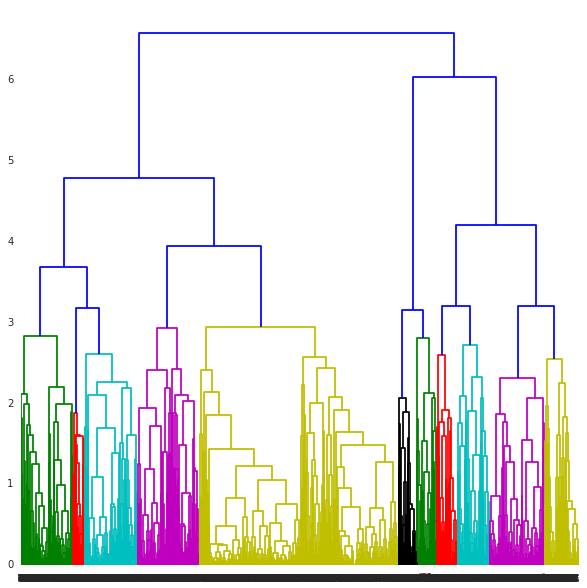

In [21]:
import time
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr

import sklearn.cluster as cluster

from sklearn.decomposition import TruncatedSVD

from scipy.spatial.distance import pdist, squareform


#import matplotlib as mpl
import seaborn as sns

numparray = df8.as_matrix()
print numparray

Z = hr.linkage(numparray, method='complete', metric='euclidean')
fig = plt.figure(figsize=(10,10))
T = hr.dendrogram(Z,color_threshold=3,leaf_font_size=4)
fig.show()



In [22]:
# Now let's retrieve the clusters
from scipy.cluster.hierarchy import fcluster
max_d = 3
clusters = fcluster(Z, max_d, criterion='distance')


In [ ]:
ghmap = gmplot.GoogleMapPlotter(36, -115, 10)
df301 = pd.DataFrame.copy(df8)

df301['actual_lat'] = finaldata['latitude']
df301['actual_long'] = finaldata['longitude']
df301['labels'] = clusters     # Give the clusters the labels from hierarchical
df310=df301[df301['labels'] == 0]
df311=df301[df301['labels'] == 1]
df312=df301[df301['labels'] == 2]
df313=df301[df301['labels'] == 3]
df314=df301[df301['labels'] == 4]
df315=df301[df301['labels'] == 5]
df316=df301[df301['labels'] == 6]
df317=df301[df301['labels'] == 7]
df318=df301[df301['labels'] == 8]
df319=df301[df301['labels'] == 9]
df320=df301[df301['labels'] == 10]
ghmap.scatter(df310['actual_lat'],df310['actual_long'], c='#00ff00', marker=False) #Green
ghmap.scatter(df311['actual_lat'],df311['actual_long'], c='#ff0000', marker=False) #Red
gmap.scatter(df312['actual_lat'],df312['actual_long'], c='#ffff00', marker=False) #Yellow
ghmap.scatter(df313['actual_lat'],df313['actual_long'], c='#FF8C00', marker=False) #DarkOrange
ghmap.scatter(df314['actual_lat'],df314['actual_long'], c='#00BFFF', marker=False) #Skyblue
ghmap.scatter(df315['actual_lat'],df315['actual_long'], c='#0000ff', marker=False) #Blue
ghmap.scatter(df316['actual_lat'],df316['actual_long'], c='#808080', marker=False) #Grey
ghmap.scatter(df317['actual_lat'],df317['actual_long'], c='#663399', marker=False) #RebeccaPurple
ghmap.scatter(df318['actual_lat'],df318['actual_long'], c='#993300', marker=False) #Brown
ghmap.scatter(df319['actual_lat'],df319['actual_long'], c='#ffffff', marker=False) #white
ghmap.scatter(df320['actual_lat'],df320['actual_long'], c='#339966', marker=False) #Greenish
ghmap.draw("hierarchicalmeans.html")

In [24]:
# Now let us look at what are the categories in each cluster
clustersOf(df310)
clustersOf(df311)
clustersOf(df312)
clustersOf(df313)
clustersOf(df314)
clustersOf(df315)
clustersOf(df316)
clustersOf(df317)
clustersOf(df318)
clustersOf(df319)
clustersOf(df320)

Italian : 0
Wine : 0
Chinese 0
sandwiches 0
sushi 0
indian 0
mediterranean 0
------------------------------
Italian : 23
Wine : 2
Chinese 28
sandwiches 33
sushi 20
indian 3
mediterranean 7
------------------------------
Italian : 3
Wine : 2
Chinese 4
sandwiches 18
sushi 6
indian 0
mediterranean 0
------------------------------
Italian : 102
Wine : 3
Chinese 5
sandwiches 94
sushi 54
indian 1
mediterranean 31
------------------------------
Italian : 21
Wine : 0
Chinese 66
sandwiches 31
sushi 64
indian 2
mediterranean 32
------------------------------
Italian : 38
Wine : 29
Chinese 171
sandwiches 134
sushi 9
indian 26
mediterranean 5
------------------------------
Italian : 3
Wine : 2
Chinese 13
sandwiches 15
sushi 3
indian 0
mediterranean 0
------------------------------
Italian : 8
Wine : 0
Chinese 9
sandwiches 12
sushi 0
indian 0
mediterranean 0
------------------------------
Italian : 18
Wine : 1
Chinese 17
sandwiches 19
sushi 6
indian 0
mediterranean 4
------------------------------


Above data gives us information about the hierarchical clustering. I chose the cluster distance to be 3 to get around 11 clusters. Most of the clusters have high amount of two or three categories.
Restaurants have been clustered together mostly by proximity than category.

In [ ]:
import time
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

import seaborn as sns
import gmplot
gmapagain = gmplot.GoogleMapPlotter(36, -115, 10)
%matplotlib inline


# Fit a mixture of Gaussians with EM using two components
gmm = mixture.GMM(n_components=13, covariance_type='diag')

t0 = time.time()

gmm.fit(numparray)

t1 = time.time()

y_pred = gmm.predict(numparray)

gmmdataframe = pd.DataFrame.copy(df8)

gmmdataframe['actual_lat'] = finaldata['latitude']
gmmdataframe['actual_long'] = finaldata['longitude']
gmmdataframe['labels'] = y_pred
gmmdataframe101 = gmmdataframe[gmmdataframe['labels'] == 0]
gmmdataframe102 = gmmdataframe[gmmdataframe['labels'] == 1]
gmmdataframe103 = gmmdataframe[gmmdataframe['labels'] == 2]
gmmdataframe104 = gmmdataframe[gmmdataframe['labels'] == 3]
gmmdataframe105 = gmmdataframe[gmmdataframe['labels'] == 4]
gmmdataframe106 = gmmdataframe[gmmdataframe['labels'] == 5]
gmmdataframe107 = gmmdataframe[gmmdataframe['labels'] == 6]
gmmdataframe108 = gmmdataframe[gmmdataframe['labels'] == 7]
gmmdataframe109 = gmmdataframe[gmmdataframe['labels'] == 8]
gmmdataframe110 = gmmdataframe[gmmdataframe['labels'] == 9]
gmmdataframe111 = gmmdataframe[gmmdataframe['labels'] == 10]
gmmdataframe112 = gmmdataframe[gmmdataframe['labels'] == 11]
gmmdataframe113 = gmmdataframe[gmmdataframe['labels'] == 12]


gmapagain.scatter(gmmdataframe101['actual_lat'],gmmdataframe101['actual_long'], c='#0000e6', marker=False)
gmapagain.scatter(gmmdataframe102['actual_lat'],gmmdataframe102['actual_long'], c='#ff0000', marker=False)
gmapagain.scatter(gmmdataframe103['actual_lat'],gmmdataframe103['actual_long'], c='#00cc00', marker=False)
gmapagain.scatter(gmmdataframe104['actual_lat'],gmmdataframe104['actual_long'], c='#b300b3', marker=False)
gmapagain.scatter(gmmdataframe105['actual_lat'],gmmdataframe105['actual_long'], c='#000066', marker=False)
gmapagain.scatter(gmmdataframe106['actual_lat'],gmmdataframe106['actual_long'], c='#808080', marker=False)
gmapagain.scatter(gmmdataframe107['actual_lat'],gmmdataframe107['actual_long'], c='#663399', marker=False)
gmapagain.scatter(gmmdataframe108['actual_lat'],gmmdataframe108['actual_long'], c='#6b8e23', marker=False)
gmapagain.scatter(gmmdataframe109['actual_lat'],gmmdataframe109['actual_long'], c='#d2691e', marker=False)
gmapagain.scatter(gmmdataframe110['actual_lat'],gmmdataframe110['actual_long'], c='#003300', marker=False)
gmapagain.scatter(gmmdataframe111['actual_lat'],gmmdataframe111['actual_long'], c='#990033', marker=False)
gmapagain.scatter(gmmdataframe112['actual_lat'],gmmdataframe112['actual_long'], c='#9900cc', marker=False)
gmapagain.scatter(gmmdataframe113['actual_lat'],gmmdataframe113['actual_long'], c='#999966', marker=False)


gmapagain.draw("gmmmap.html")



As we can see below from the cluster information of gmm clustering, the GMM clusters are divided categorically. We can find clusters where every element is only sushi or only italian or only sandwiches etc. Few clusters have mixture of category types. 

In [26]:
#Information about GMM Clustering
clustersOf(gmmdataframe101)
clustersOf(gmmdataframe102)
clustersOf(gmmdataframe103)
clustersOf(gmmdataframe104)
clustersOf(gmmdataframe105)
clustersOf(gmmdataframe106)
clustersOf(gmmdataframe107)
clustersOf(gmmdataframe108)
clustersOf(gmmdataframe109)
clustersOf(gmmdataframe110)
clustersOf(gmmdataframe111)
clustersOf(gmmdataframe112)
clustersOf(gmmdataframe113)

Italian : 0
Wine : 0
Chinese 0
sandwiches 0
sushi 175
indian 0
mediterranean 0
------------------------------
Italian : 20
Wine : 51
Chinese 0
sandwiches 0
sushi 0
indian 36
mediterranean 1
------------------------------
Italian : 0
Wine : 0
Chinese 0
sandwiches 0
sushi 0
indian 0
mediterranean 0
------------------------------
Italian : 3
Wine : 0
Chinese 0
sandwiches 0
sushi 0
indian 0
mediterranean 23
------------------------------
Italian : 0
Wine : 0
Chinese 0
sandwiches 0
sushi 0
indian 0
mediterranean 0
------------------------------
Italian : 0
Wine : 0
Chinese 0
sandwiches 0
sushi 0
indian 0
mediterranean 0
------------------------------
Italian : 0
Wine : 0
Chinese 0
sandwiches 0
sushi 0
indian 0
mediterranean 0
------------------------------
Italian : 0
Wine : 0
Chinese 0
sandwiches 447
sushi 0
indian 0
mediterranean 0
------------------------------
Italian : 260
Wine : 0
Chinese 0
sandwiches 0
sushi 0
indian 0
mediterranean 0
------------------------------
Italian : 0
Wine :

Visualize your clusters using each technique. Label your clusters. **(10 pts)**

Please refer to the .html files for visualisation. 

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

Lets detect outliers for kmeans clusters. In Kmeans we have the cluster centroids for all the clusters. The below code finds the outlier that is far away farthest away from the cluster centroid.

In [27]:
from scipy.spatial import distance
def findClusterOutlier(dfcdata):
    dfc = pd.DataFrame.copy(dfcdata)
    del dfc['actual_lat']
    del dfc['actual_long']
    del dfc['labels']
    distancelist = []
    nump110 = dfc.as_matrix()
    for i in range(nump110.shape[0]):
        dst = distance.euclidean(nump110[i],centroids[0])
        distancelist.append(dst)
    dfc['Distance_Mean'] = distancelist
    
    # Find the max of Distance List
    print "Outlier of the Cluster is \n"
    clustersOf(dfc[dfc['Distance_Mean'] == max(dfc['Distance_Mean'])]) # We are taking the points that are farthest
    print "Actual Cluster for the above outlier \n"
    clustersOf(dfc)
                                                                      
                                                                       
                                                                       



In [28]:
findClusterOutlier(df110)
findClusterOutlier(df111)
findClusterOutlier(df112)
findClusterOutlier(df113)
findClusterOutlier(df114)
findClusterOutlier(df115)
findClusterOutlier(df116)
findClusterOutlier(df117)
findClusterOutlier(df118)
findClusterOutlier(df119)
findClusterOutlier(df110)
findClusterOutlier(df111)
findClusterOutlier(df112)
findClusterOutlier(df113)

Outlier of the Cluster is 

Italian : 0
Wine : 0
Chinese 1
sandwiches 0
sushi 0
indian 0
mediterranean 0
------------------------------
Actual Cluster for the above outlier 

Italian : 6
Wine : 2
Chinese 13
sandwiches 0
sushi 6
indian 2
mediterranean 7
------------------------------
Outlier of the Cluster is 

Italian : 1
Wine : 0
Chinese 0
sandwiches 0
sushi 0
indian 0
mediterranean 0
------------------------------
Actual Cluster for the above outlier 

Italian : 28
Wine : 0
Chinese 16
sandwiches 24
sushi 19
indian 3
mediterranean 10
------------------------------
Outlier of the Cluster is 

Italian : 0
Wine : 0
Chinese 0
sandwiches 1
sushi 0
indian 0
mediterranean 0
------------------------------
Actual Cluster for the above outlier 

Italian : 29
Wine : 9
Chinese 19
sandwiches 30
sushi 19
indian 1
mediterranean 5
------------------------------
Outlier of the Cluster is 

Italian : 0
Wine : 1
Chinese 0
sandwiches 0
sushi 0
indian 0
mediterranean 1
------------------------------
Actua

As seen above for each cluster I have obtained the outlier by calculating the distance between the cetroid and the each point in the cluster. I have taken the point that is farthest away from the center. The outliers could be due to
two factors: 
1) The Restaurant is farther away from the cluster visa vis location
2) The categorys that are true for the restaurant are very few in the cluster.

Above we see few types of outliers:
A restaurant that does not belong to any of the category but is part of the cluster due to proximity
Outlier of the Cluster is 

Italian : 0
Wine : 0
Chinese 0
sandwiches 0
sushi 0
indian 0
mediterranean 0
------------------------------
Actual Cluster for the above outlier 

Italian : 18
Wine : 0
Chinese 17
sandwiches 42
sushi 12
indian 3
mediterranean 10
------------------------------

As restaurant that belong to the category but is far way!

Outlier of the Cluster is 

Italian : 0
Wine : 0
Chinese 1
sandwiches 0
sushi 0
indian 0
mediterranean 0
------------------------------
Actual Cluster for the above outlier 

Italian : 0
Wine : 2
Chinese 194
sandwiches 1
sushi 6
indian 0
mediterranean 0

Give a short (detailed) analysis comparing the 3 techniques. **(10 pts)**

K Means : The K Means algorithm worked best with my data. With K means we could find clusters of culinary districts that are close together and some clusters with mixed data. The error of the K means was constantly decreasing and hence it was not possible to choose the appropriate number of clusters easily. 

Hierarchical Clustering: The clusters obtained through the hierarchical clustering did not have many pure categorical clusters. Many of the clusters had equal combination of all the category types. 

GMM Clustering: The clustering data obtained from GMM were mostly categorical. From GMM we were able to obtain only Chinese,only Italian, Only Sushi restuarants etc. Location seems to have had lesser weight in GMM clustering.

Overall few culinary districts could be seen on the map with all the algorithms as could be seen from the map. Even with clusters there are areas that are dense which are a good indication of the existence of a culinary district. All the clusters meet at a central area. This could probably be downtown or important business area with lot of restaurants.

-----------------

In [276]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()